In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig imges of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!rm -rf '/content/drive/My Drive/lfw/__MACOSX'


In [4]:
path = '/content/drive/My Drive/lfw'



In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


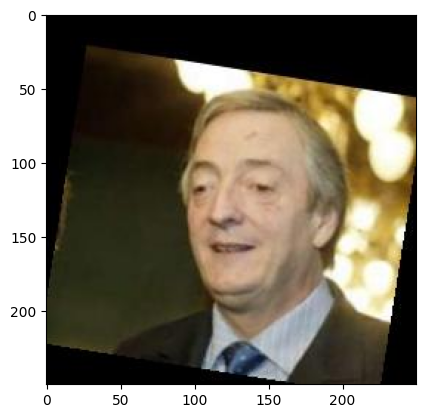

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# taking out a sample image from dataloader
for x, _ in dataloader:
    img_smple = x[0]  # First image will be shown from the batch
    break

# Print dimensions of the sample image
dimension_of_image = img_smple.shape

# Explain of each dimension the code below
explain = {
    "First Dimension": f"{dimension_of_image[0]} (Color Channels) - Represents the number of color channels. In this case, 3 channels for RGB (Red, Green, Blue).",
    "Second Dimension": f"{dimension_of_image[1]} (Height) - Height of the image in pixels.",
    "Third Dimension": f"{dimension_of_image[2]} (Width) - Width of the image in pixels."
}

(dimension_of_image, explain)


(torch.Size([3, 250, 250]),
 {'First Dimension': '3 (Color Channels) - Represents the number of color channels. In this case, 3 channels for RGB (Red, Green, Blue).',
  'Second Dimension': '250 (Height) - Height of the image in pixels.',
  'Third Dimension': '250 (Width) - Width of the image in pixels.'})

**Explaination what each dimension means:**

**Dimension One: Color Variety (3 Channels)** - This refers to the range of colors that are captured in the image using the RGB which consist of Red, Green, and Blue color model, which makes use of three channels.

**Dimension Two:** - This represents the image's vertical size expressed in pixels. It is **250** pixels tall.

**Dimension Three: Horizontal Size (250 Pixels in Width)**- This dimension represents the width of the image in pixels.

As a result, every image in your dataset has a **250x250 pixel** composition and a vivid color spectrum that was recorded using **3** channels (RGB).





# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # different layers for the encoders
        self.enc_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        # different layers for the decoder
        self.dec_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid()
        )

    def encoder(self, x):
        return self.enc_layers(x)

    def decoder(self, x):
        return self.dec_layers(x)

    def forward(self, x): #forward path
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Model Explanation:**

Encoder: Convolutional layers with batch normalization and ReLU activations are used in the encoder technique. Its goal is to create a hidden representation from the input image.

Decoder: The decoder approach uses a Sigmoid layer and transpose convolutional layers with batch normalization and ReLU activations to rebuild the image from its hidden representation.

Data Flow: By directing the input via the encoder to obtain the hidden representation and then through the decoder to rebuild the original image, the forward technique creates the data flow.

This structure guarantees adherence to the need for separate functions for the encoder and decoder functions in the AE class.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Creating an instance the model given
model = AE()

# trying evaluation mode
model.eval()

# sample image testing
for x, _ in dataloader:
    img_smple = x[0].unsqueeze(0)  #batch dimension
    output = model(img_smple)
    shape_of_inp = img_smple.shape
    shape_encoder_out = model.encoder(img_smple).shape
    shape_decoder_out = output.shape

    if shape_of_inp == shape_decoder_out:
        print("Dimension check is pass: the dimension of input and output get matched, so forward path is working properly.")
    else:
        print("Dimension check is failed: the dimension of Input and output dimensions did not get matched.")

    print("shape of the Input:", shape_of_inp)
    print("Encoder output shape:", shape_encoder_out)
    print("decoder output shape:", shape_decoder_out)
    break

Dimension check is pass: the dimension of input and output get matched, so forward path is working properly.
shape of the Input: torch.Size([1, 3, 250, 250])
Encoder output shape: torch.Size([1, 64, 32, 32])
decoder output shape: torch.Size([1, 3, 250, 250])


**Input Shape:** The format of the sample image you gave the model is referred to here.

**Encoded Output Shape:** The dimensions of the encoder's hidden representation.

**Decoded Output Shape:** This should reflect the input arrangement, demonstrating how well the decoder was able to rebuild the image from the encoded representation.

In order to make sure the **input and output sizes match**, dimensions must be checked. If they do, it confirms that the **forward path of the autoencoder is operating correctly.**

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
# first calculating and then printing the total number of parameters are there in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters that are trained:", total_params)

Total number of parameters that are trained: 47187


**Total Number of Parameters:** It will be the sum of all the parameters that are trainable which are present in the model.



In [12]:
# optimizer is getting created
optim = torch.optim.Adam(model.parameters(), lr=0.001)#Adam optimizer is used as a first default choice.

**Optimizer:** The Adam optimizer was chosen because of how well it trains deep learning models. It combines the advantages of the two previous stochastic gradient descent algorithms: Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad). The degree to which the model is modified in response to the predicted error with each update of its weights depends on the learning rate (lr). 0.001 is a commonly used initial value for the learning rate in a variety of models.




In [13]:
# loss function
# Mean Squared Error (MSE) loss is the first choice,
# calculate the difference between reconstruct image and otrignal image.
loss_function = torch.nn.MSELoss()

**Explantion about what loss function used:**

Autoencoders frequently use the Mean Squared Error (MSE) loss, especially when doing tasks like picture reconstruction. The average of the squared discrepancies between the original input image and the decoder's output, or the reconstruct image, is calculated as the loss measure. Its efficacy stems from its capacity to penalize greater errors more severely than minor ones, which in turn produces a reconstruction that is more accurate.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
# total number of epochs for running
epoch_total = 10

# Training loop
for epoch in range(epoch_total):
    loss_total = 0

    for data, _ in dataloader:
        # Data is a batch of imges
        imges = data

        # Zero the gradients
        optim.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        reconstruct = model(imges)

        # Calculate the loss
        loss = loss_function(reconstruct, imges)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optim.step()

        # Update running training loss
        loss_total += loss.item() * imges.size(0)

    # Print average loss for the epoch
    avg_loss = loss_total / len(dataloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epoch_total, avg_loss))


Epoch [1/10], Loss: 0.0223
Epoch [2/10], Loss: 0.0043
Epoch [3/10], Loss: 0.0027
Epoch [4/10], Loss: 0.0023
Epoch [5/10], Loss: 0.0020
Epoch [6/10], Loss: 0.0017
Epoch [7/10], Loss: 0.0014
Epoch [8/10], Loss: 0.0013
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0010


**Iterative Training Process: :** The dataset is processed multiple times throughout the training phase. It processes the data in batches, determines the loss for each batch, performs backpropagation, and modifies the model parameters during each cycle.

**Loss Evaluation:** Following the conclusion of each cycle, the total loss is shown. This shows the average loss for every data point in the training dataset and provides information about how well the model can recreate the input images.

**Troubleshooting if Loss is Not Decreasing:**

**Adjust the Learning Rate:** Adjust the learning rate if it isn't decreasing; it may be set too high or too low. Try out different modifications.

**Assess the Model's Design** Examine your model's structural layout. It could be excessively simple or complex for the task at hand. Strike the ideal balance.

**Validate Data Processing::**For images, check normalization, resizing, and other steps.

**Stop Overfitting:**If your model is overfitting, think about incorporating regularization methods such as dropout to enhance performance.

**Optimize Batch Size:**Experiment with different batch sizes during training. A smaller batch size can act as a regularization tool, potentially reducing generalization errors.

**Randomize Data Order:** Ensure your data is shuffled effectively to prevent the model from learning patterns based on data order.


##  Step 7

Take a random image from the dataset and plot it against the reconstruct (encoded + decoded) image.

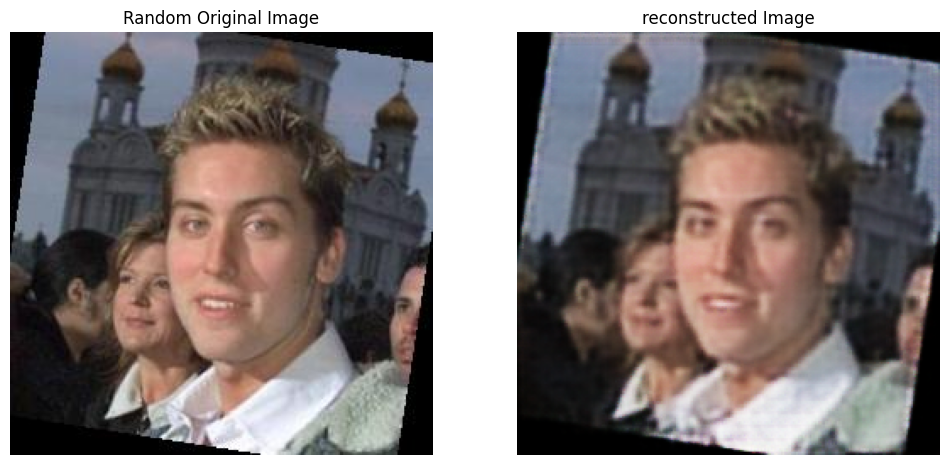

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# eval mode in the model
model.eval()

# taking out the random image from dataloader
iter_data = iter(dataloader)
imges, _ = next(iter_data)
image = imges[torch.randint(0, len(imges), (1,)).item()]

# sending the image from the autoencoder to get image that is reconstructed
image = image.unsqueeze(0)
reconstruct = model(image).detach().squeeze(0)

# into numpy arrays for plotting
# C,H,W to H,c,W format for plotting
random_original_image = np.transpose(image.squeeze(0).numpy(), (1, 2, 0))
reconstruct_image = np.transpose(reconstruct.numpy(), (1, 2, 0))

#potting random orignal image from dataset and reconstructed image side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(random_original_image)
plt.title('Random Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstruct_image)
plt.title('reconstructed Image')
plt.axis('off')

plt.show()


The **original and reconstructed images** are represented by PyTorch tensors, which are then converted into numpy arrays and formatted appropriately for display.

The original and rebuilt images are then compared side by side using matplotlib to facilitate visual evaluation.

##  Step 8

In step 7, add a small normaly distrubuted add_noise to the latent (hidden) representation of the input image and then decode it again. How is adding add_noise affecting the decoded image ?

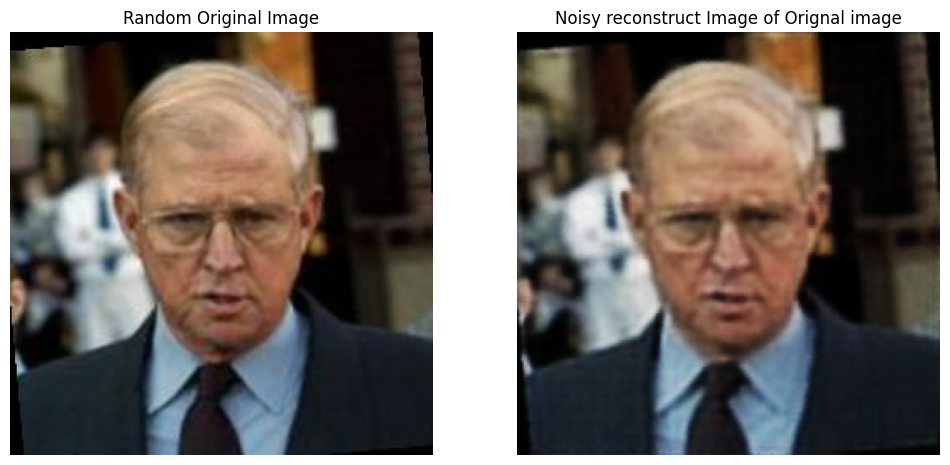

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# eval mode in the model
model.eval()

# taking out the random image again from dataloader
iter_data = iter(dataloader)
imges, _ = next(iter_data)
image = imges[torch.randint(0, len(imges), (1,)).item()]

# passing image through encoder
image = image.unsqueeze(0)
ltnt = model.encoder(image)

# passing small noise to the latent reppresentation
add_noise = torch.randn_like(ltnt) * 0.05  # Adjusting the multiplier
noisy_ltnt = ltnt + add_noise

#Decoding the noisy ltnt representation
noisy_reconstruct = model.decoder(noisy_ltnt).detach().squeeze(0)

# tensors to numpy arrays for plotting the image
random_original_image = np.transpose(image.squeeze(0).numpy(), (1, 2, 0))
noisy_reconstruct_image = np.transpose(noisy_reconstruct.numpy(), (1, 2, 0))

# plotting the random orignal image and the noisy image of that orignal image side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(random_original_image)
plt.title('Random Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_reconstruct_image)
plt.title('Noisy reconstruct Image of Orignal image')
plt.axis('off')

plt.show()


**Explanation of how adding add_noise affecting the decoded image:**

As can be seen in the result, disturbing the hidden information in an autoencoder typically results in a reconstructed image that seems more distorted and less clear than the original. In our case, the additional noise made the image look fuzzier, suggesting that even little changes to the encoded data can have a big effect on how well the autoencoder decodes. Essentially, the noise obscures the critical characteristics that the autoencoder has learned, which lowers the reconstructed image's overall quality and detail.

**Citation**: *https://chat.openai.com/*